In [1]:
%tensorflow_version 2.x
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import pickle
from sklearn.utils import class_weight
from keras import regularizers
import random
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
from tensorflow.keras import models
from google.colab import drive
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
out_path = '/content/drive/MyDrive/Barsellotti_Paolini'

In [5]:
def change_label_bm(labels):
  new_labels = list()
  
  for label in labels:
    if label==1 or label==3:#benign
      new_labels.append(0)
    if label==2 or label==4:#malignant
      new_labels.append(1)
  return np.array(new_labels)

In [4]:
def toRGB(images):
  tmp_images = []
  for image in images:
    reshaped_image = image.reshape((150,150,1))
    rgb_image = np.repeat(reshaped_image, 3, 2)
    rgb_image = rgb_image / 65535
    tmp_images.append(rgb_image)
  tmp_images = np.array(tmp_images)
  return tmp_images


In [3]:
model1 = tf.keras.models.load_model(os.path.join(out_path, "models/scratch_model_dccnn_v1_bm"))# dccnn bm
model2 = tf.keras.models.load_model(os.path.join(out_path, "models/pretrained_vgg16_trainable_bm"))#vgg 3 learning phases bm
model3 = tf.keras.models.load_model(os.path.join(out_path, "models/pretrained_inception_trainable_bm"))#inception all layers fine tuned

In [6]:
# PREDICTIONS FOR DCCNN
test_images_tensor = np.load(out_path + '/public_test_tensor.npy')
test_images_labels = np.load(out_path + '/public_test_labels.npy')
test_images_tensor = test_images_tensor[1::2]
test_images_labels = test_images_labels[1::2]
test_images_labels = change_label_bm(test_images_labels)
test_images_tensor = test_images_tensor.reshape((336, 150, 150, 1))


test_images_tensor = test_images_tensor.astype('float32') / 65535
test_loss, test_acc = model1.evaluate(test_images_tensor,test_images_labels)
predictions1 = (model1.predict(test_images_tensor) > 0.5).astype("int32")


11/11 [==============================] - 10s 123ms/step - loss: 0.6270 - accuracy: 0.6458


In [7]:
# PREDICTIONS FOR VGG
test_images_tensor = np.load(out_path + '/public_test_tensor.npy')
test_images_labels = np.load(out_path + '/public_test_labels.npy')
test_images_tensor = test_images_tensor[1::2]
test_images_labels = test_images_labels[1::2]
test_images_labels = change_label_bm(test_images_labels)


test_images_tensor = toRGB(test_images_tensor)

test_loss, test_acc = model2.evaluate(test_images_tensor,test_images_labels)
predictions2 = (model2.predict(test_images_tensor) > 0.5).astype("int32")

11/11 [==============================] - 2s 106ms/step - loss: 0.5677 - accuracy: 0.7232


In [8]:
# PREDICTIONS FOR INCEPTION
test_loss, test_acc = model3.evaluate(test_images_tensor,test_images_labels)
predictions3 = (model3.predict(test_images_tensor) > 0.5).astype("int32")

11/11 [==============================] - 2s 66ms/step - loss: 0.5984 - accuracy: 0.6607


# Majority Voting

[[154  65]
 [ 37  80]]
              precision    recall  f1-score   support

           0       0.81      0.70      0.75       219
           1       0.55      0.68      0.61       117

    accuracy                           0.70       336
   macro avg       0.68      0.69      0.68       336
weighted avg       0.72      0.70      0.70       336



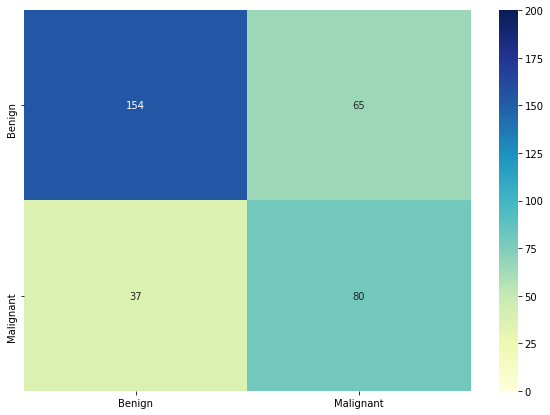

In [ ]:
# MODEL ENSEMBLING 1: MAJORITY VOTING
from sklearn import metrics
from matplotlib import pyplot as plt

import seaborn as sn
import pandas as pd

final_preds = ((1/3) * (predictions1+predictions2+predictions3) > 0.5).astype("int32")

print(metrics.confusion_matrix(test_images_labels, final_preds))

array = metrics.confusion_matrix(test_images_labels, final_preds)
df_cm = pd.DataFrame(array, index = ["Benign", "Malignant"],
                  columns = ["Benign", "Malignant"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, vmin=0, vmax=200, annot=True, fmt="d", cmap="YlGnBu")
print(metrics.classification_report(test_images_labels,final_preds))


In [ ]:
dictionary = metrics.classification_report(test_images_labels,final_preds,output_dict=True)
print(dictionary["accuracy"])

0.6964285714285714


In [ ]:
# save final pred into a file
np.save(os.path.join(out_path,"miscellaneous/majority_voting_benign_malignant_predictions"), final_preds)

# Averaging

11/11 [==============================] - 0s 30ms/step - loss: 0.5984 - accuracy: 0.6607
[[159  60]
 [ 36  81]]
              precision    recall  f1-score   support

           0       0.82      0.73      0.77       219
           1       0.57      0.69      0.63       117

    accuracy                           0.71       336
   macro avg       0.69      0.71      0.70       336
weighted avg       0.73      0.71      0.72       336



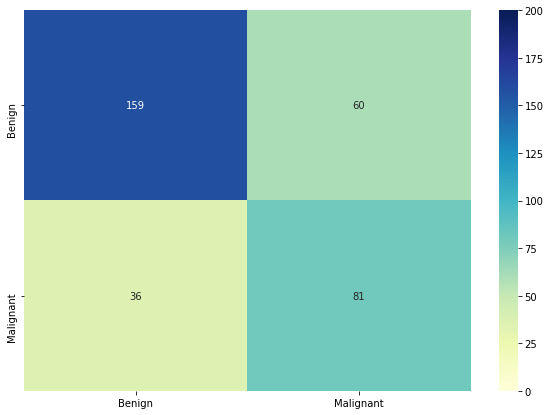

In [9]:
# MODEL ENSEMBLING 2: AVERAGING

# Weights
with open(out_path + '/histories/scratch_model_dccnn_v1_bm_history', 'rb') as file:
    history=pickle.load(file)
index = history['val_loss'].index(min(history['val_loss']))
val_accuracy1 = history['val_accuracy'][index]

with open(out_path + '/histories/pretrained_vgg16_trainable_bm_history', 'rb') as file:
    history=pickle.load(file)
index = history['val_loss'].index(min(history['val_loss']))
val_accuracy2 = history['val_accuracy'][index]

with open(out_path + '/histories/pretrained_inception_trainable_bm_history', 'rb') as file:
    history=pickle.load(file)
index = history['val_loss'].index(min(history['val_loss']))
val_accuracy3 = history['val_accuracy'][index]

tot = val_accuracy1+val_accuracy2+val_accuracy3
weight1 = val_accuracy1/tot
weight2 = val_accuracy2/tot
weight3 = val_accuracy3/tot


# PREDICTIONS FOR DCCNN
test_images_tensor = np.load(out_path + '/public_test_tensor.npy')
test_images_labels = np.load(out_path + '/public_test_labels.npy')
test_images_tensor = test_images_tensor[1::2]
test_images_labels = test_images_labels[1::2]
test_images_labels = change_label_bm(test_images_labels)
test_images_tensor = test_images_tensor.reshape((336, 150, 150, 1))

test_images_tensor = test_images_tensor.astype('float32') / 65535
test_loss, test_acc = model1.evaluate(test_images_tensor,test_images_labels)
predictions1 = model1.predict(test_images_tensor)
# PREDICTIONS FOR VGG
test_images_tensor = np.load(out_path + '/public_test_tensor.npy')
test_images_labels = np.load(out_path + '/public_test_labels.npy')
test_images_tensor = test_images_tensor[1::2]
test_images_labels = test_images_labels[1::2]
test_images_labels = change_label_bm(test_images_labels)


test_images_tensor = toRGB(test_images_tensor)

test_loss, test_acc = model2.evaluate(test_images_tensor,test_images_labels)
predictions2 = model2.predict(test_images_tensor) 
# PREDICTIONS FOR INCEPTION
test_loss, test_acc = model3.evaluate(test_images_tensor,test_images_labels)
predictions3 = model3.predict(test_images_tensor)


from sklearn import metrics
from matplotlib import pyplot as plt

import seaborn as sn
import pandas as pd

final_preds = ((weight1*predictions1+weight2*predictions2+weight3*predictions3) > 0.5).astype("int32")

#print(final_preds)
print(metrics.confusion_matrix(test_images_labels, final_preds))

array = metrics.confusion_matrix(test_images_labels, final_preds)
df_cm = pd.DataFrame(array, index = ["Benign", "Malignant"],
                  columns = ["Benign", "Malignant"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, vmin=0, vmax=200, annot=True, fmt="d", cmap="YlGnBu")
print(metrics.classification_report(test_images_labels,final_preds))


In [13]:
dictionary = metrics.classification_report(test_images_labels,final_preds,output_dict=True)
print(dictionary["accuracy"])
# F2 metric for BM models
from sklearn.metrics import fbeta_score

print(fbeta_score(test_images_labels, final_preds, beta=2))

fpr1,tpr1,th1 = metrics.roc_curve(test_images_labels,final_preds)

roc_auc1 = metrics.roc_auc_score(test_images_labels,final_preds)

print(roc_auc1)


0.7142857142857143
0.6650246305418718
0.7091675447839831


In [ ]:
# save final pred into a file
np.save(os.path.join(out_path,"miscellaneous/averaging_benign_malignant_predictions"), final_preds)

# Model Stacking with Neural Network as meta-classifiers

In [ ]:
def load_training():
  images = np.load(os.path.join(out_path,'train_tensor.npy'))
  labels = np.load(os.path.join(out_path,'train_labels.npy'))
  return images,labels
images, labels= load_training()
labels = change_label_bm(labels[1::2])
images = images[1::2]

In [ ]:
# Create a new Functional Model in Keras that gets the three models

from keras.utils import Sequence
from sklearn.model_selection import train_test_split

# Transform data in RGB
rgb_images = toRGB(images)
images = images / 65535
images = images.reshape((2676, 150, 150, 1))

# Take the validation split from both rgb_images and images
randomize = np.arange(len(images))
np.random.shuffle(randomize)
images = images[randomize]
rgb_images = rgb_images[randomize]
labels = labels[randomize]
images_train, images_val, rgb_images_train, rgb_images_val, labels_train, labels_val = train_test_split(images, rgb_images, labels, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

#The double generator will pass an input in grayscale and an input in RGB
class DoubleGenerator(Sequence):
    def __init__(self, gen1, gen2):
       self.gen1 = gen1
       self.gen2 = gen2

    def __len__(self):
       return len(self.gen1)

    def __getitem__(self, i):
       x1,y = self.gen1[i]
       x2,y2 = self.gen2[i]
       return (x1,x2), y

In [ ]:
from keras.layers.core import Lambda
from keras import backend as K
from keras.layers import Input

gray_input_shape = (150,150,1)
rgb_input_shape = (150,150,3)
gray_input = Input(gray_input_shape)
rgb_input = Input(rgb_input_shape)


dccnn_model = tf.keras.models.load_model(os.path.join(out_path, "models/scratch_model_dccnn_v1_bm"))
dccnn_model.trainable = False
vgg16_model = tf.keras.models.load_model(os.path.join(out_path, "models/pretrained_vgg16_trainable_bm"))
vgg16_model.trainable = False
inception_model = tf.keras.models.load_model(os.path.join(out_path, "models/pretrained_inception_trainable_bm"))
inception_model.trainable = False

dccnn = dccnn_model(gray_input)
vgg16 = vgg16_model(rgb_input)
inception = inception_model(rgb_input)

L1_layer = Lambda(lambda tensors:K.concatenate(tensors))
L1_concat = L1_layer([dccnn, vgg16, inception])

dense1 = tf.keras.layers.Dense(4, activation='relu',kernel_regularizer=regularizers.l2(1e-6))(L1_concat)
dense2 = tf.keras.layers.Dense(2, activation='relu',kernel_regularizer=regularizers.l2(1e-6))(dense1)
prediction = tf.keras.layers.Dense(1,activation='sigmoid',kernel_regularizer=regularizers.l2(1e-6))(dense2)


model = models.Model(inputs=[gray_input,rgb_input],outputs=prediction)

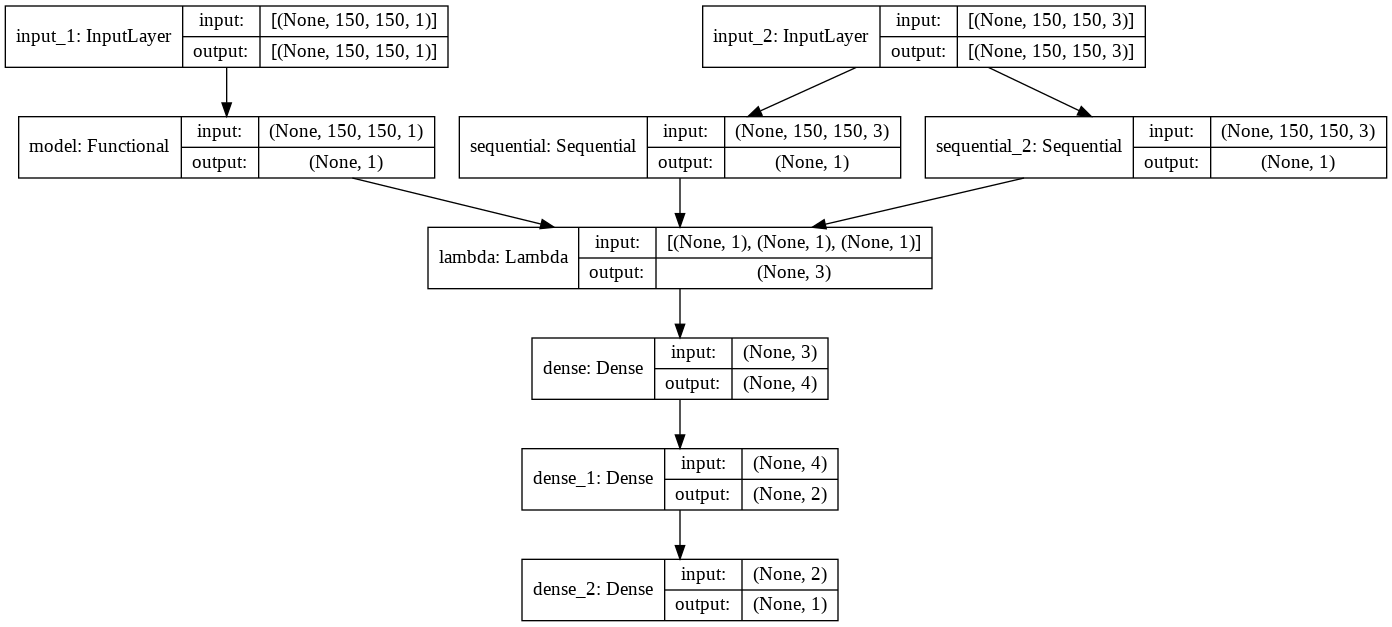

In [ ]:
tf.keras.utils.plot_model(model, to_file="img.png", show_shapes=True)

In [ ]:
SEED = 12345
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

datagen = ImageDataGenerator()
train_generator = DoubleGenerator(datagen.flow(images_train,
                               labels_train,
                               batch_size=32,
                               shuffle=True,
                               seed=SEED),
                             datagen.flow(rgb_images_train,
                               labels_train,
                               batch_size=32,
                               shuffle=True,
                               seed=SEED))

valid_generator = DoubleGenerator(datagen.flow(images_val,
                               labels_val,
                               batch_size=32,
                               seed=SEED),
                             datagen.flow(rgb_images_val,
                               labels_val,
                               batch_size=32,
                               seed=SEED))

optimizer = tf.keras.optimizers.Adam(0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

checkpoint_filepath = '/tmp/checkpoint'

checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', 
                              verbose=1, save_best_only=True, mode='min',save_weights_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

history = model.fit(train_generator,
          validation_data=valid_generator,
          callbacks=[es,checkpoint],
          epochs=250)

model.load_weights(checkpoint_filepath)

Epoch 1/250
63/63 [==============================] - 38s 346ms/step - loss: 0.6732 - accuracy: 0.5659 - val_loss: 0.6655 - val_accuracy: 0.6428

Epoch 00001: val_loss improved from inf to 0.66550, saving model to /tmp/checkpoint
Epoch 2/250
63/63 [==============================] - 16s 262ms/step - loss: 0.6630 - accuracy: 0.6586 - val_loss: 0.6525 - val_accuracy: 0.6786

Epoch 00002: val_loss improved from 0.66550 to 0.65254, saving model to /tmp/checkpoint
Epoch 3/250
63/63 [==============================] - 17s 266ms/step - loss: 0.6530 - accuracy: 0.7067 - val_loss: 0.6396 - val_accuracy: 0.7040

Epoch 00003: val_loss improved from 0.65254 to 0.63958, saving model to /tmp/checkpoint
Epoch 4/250
63/63 [==============================] - 17s 272ms/step - loss: 0.6393 - accuracy: 0.7110 - val_loss: 0.6266 - val_accuracy: 0.7474

Epoch 00004: val_loss improved from 0.63958 to 0.62665, saving model to /tmp/checkpoint
Epoch 5/250
63/63 [==============================] - 17s 278ms/step - lo

In [ ]:
# save model and model history
model.save(os.path.join(out_path,"models/ensembling_stacking_bm"))
with open(out_path+'/histories/ensembling_stacking_bm_history', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ProgettoMIRCV/Ensembling/stacking_bm_2/assets


In [19]:
with open(out_path + '/histories/ensembling_stacking_bm_history', 'rb') as file:
    history=pickle.load(file)

model = tf.keras.models.load_model(os.path.join(out_path, "models/ensembling_stacking_bm"))

In [20]:
index = history['val_loss'].index(min(history['val_loss']))
print("Epochs: ", index)
print("Accuracy: ", history['accuracy'][index])
print("Loss: ", history['loss'][index])
print("Val accuracy: ", history['val_accuracy'][index])
print("Val loss: ", history['val_loss'][index])

Epochs:  249
Accuracy:  0.7747882604598999
Loss:  0.4474318027496338
Val accuracy:  0.7967115044593811
Val loss:  0.4382578432559967


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


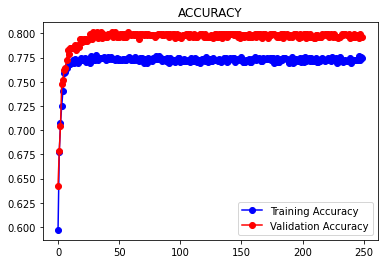

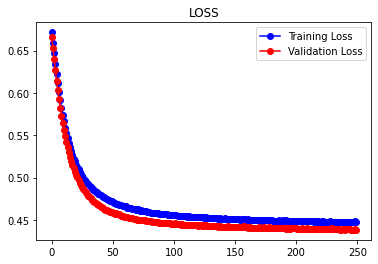

In [ ]:
import matplotlib.pyplot as plt

print(history.keys())
# see how the accuracy and the loss change during training
plt.title('ACCURACY')
plt.plot(history['accuracy'],'bo-',label = 'Training Accuracy')
plt.plot(history['val_accuracy'],'ro-',label = 'Validation Accuracy')
plt.legend()
plt.show()
plt.title('LOSS')
plt.plot(history['loss'],'bo-',label = 'Training Loss')
plt.plot(history['val_loss'],'ro-',label = 'Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Test set 

test_images_tensor = np.load(out_path + '/public_test_tensor.npy')
test_images_labels = np.load(out_path + '/public_test_labels.npy')
test_images_tensor = test_images_tensor[1::2]

test_images_labels = change_label_bm(test_images_labels[1::2])

# transform array in pairs of (baseline,patch)

rgb_test_images = toRGB(test_images_tensor)
test_images_tensor = test_images_tensor / 65535

test_images_tensor = test_images_tensor.reshape((336, 150, 150, 1))


print(test_images_labels.shape)
test_loss, test_acc = model.evaluate((test_images_tensor, rgb_test_images),test_images_labels)


(336,)
11/11 [==============================] - 19s 662ms/step - loss: 0.5743 - accuracy: 0.7589


In [ ]:
# confusion matrix
from sklearn import metrics
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

predictions = (model.predict((test_images_tensor, rgb_test_images)) > 0.5).astype("int32")


print(metrics.confusion_matrix(test_images_labels, predictions))
array = metrics.confusion_matrix(test_images_labels, predictions)
df_cm = pd.DataFrame(array, index = ["Benign", "Malignant"],
                  columns = ["Benign", "Malignant"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, vmin=0, vmax=200, annot=True, fmt="d", cmap="YlGnBu")
print(metrics.classification_report(test_images_labels,predictions))

In [ ]:
# save final pred into a file
np.save(os.path.join(out_path,"miscellaneous/stacking_benign_malignant_predictions"), predictions)

# Model stacking with Non-Deep Learning classifiers as Meta-Classifiers

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import pickle
from sklearn.utils import class_weight
from keras import regularizers
import random
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
from tensorflow.keras import models
from google.colab import drive
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
out_path = '/content/drive/MyDrive/Barsellotti_Paolini'

In [ ]:
def change_label(labels):
  new_labels = list()
  
  for label in labels:
    if label==1 or label==3:#benign
      new_labels.append(0)
    if label==2 or label==4:#malignant
      new_labels.append(1)
  return np.array(new_labels)

def toRGB(images):
  tmp_images = []
  for image in images:
    reshaped_image = image.reshape((150,150,1))
    rgb_image = np.repeat(reshaped_image, 3, 2)
    rgb_image = rgb_image / 65535
    tmp_images.append(rgb_image)
  tmp_images = np.array(tmp_images)
  return tmp_images


In [ ]:
def load_training():
  images = np.load(os.path.join(out_path,'train_tensor.npy'))
  labels = np.load(os.path.join(out_path,'train_labels.npy'))
  return images,labels
images, labels= load_training()
labels = change_label(labels[1::2])
images = images[1::2]

In [ ]:
# Create a new Functional Model in Keras that gets the three models

from keras.utils import Sequence
from sklearn.model_selection import train_test_split

# Transform data in RGB
rgb_images = toRGB(images)
images = images / 65535
images = images.reshape((2676, 150, 150, 1))

# Take the validation split from both rgb_images and images
randomize = np.arange(len(images))
np.random.shuffle(randomize)
images = images[randomize]
rgb_images = rgb_images[randomize]
labels = labels[randomize]


In [ ]:
from keras.layers.core import Lambda
from keras import backend as K
from keras.layers import Input
gray_input_shape = (150,150,1)
rgb_input_shape = (150,150,3)
gray_input = Input(gray_input_shape)
rgb_input = Input(rgb_input_shape)

dccnn_model = tf.keras.models.load_model(os.path.join(out_path, "models/scratch_model_dccnn_v1_bm"))
dccnn_model.trainable = False
vgg16_model = tf.keras.models.load_model(os.path.join(out_path, "models/pretrained_vgg16_trainable_bm"))
vgg16_model.trainable = False
inception_model = tf.keras.models.load_model(os.path.join(out_path, "models/pretrained_inception_trainable_bm"))
inception_model.trainable = False

# create new training set
training_predictions_dccnn = np.array(dccnn_model.predict(images))
training_predictions_vgg16 = np.array(vgg16_model.predict(rgb_images))
training_predictions_inception = np.array(inception_model.predict(rgb_images))

In [ ]:
from sklearn import metrics
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC

print(training_predictions_dccnn.shape)
new_training = np.concatenate((training_predictions_dccnn,training_predictions_vgg16,training_predictions_inception), axis=1)
test_images_tensor = np.load(out_path + '/public_test_tensor.npy')
test_images_labels = np.load(out_path + '/public_test_labels.npy')
test_images_tensor = test_images_tensor[1::2]

test_images_labels = change_label(test_images_labels[1::2])
rgb_test_images = toRGB(test_images_tensor)
test_images_tensor = test_images_tensor / 65535
test_images_tensor = test_images_tensor.reshape((336, 150, 150, 1))


test_predictions_dccnn = np.array(dccnn_model.predict(test_images_tensor))
test_predictions_vgg16 = np.array(vgg16_model.predict(rgb_test_images))
test_predictions_inception = np.array(inception_model.predict(rgb_test_images))

new_test = np.concatenate((test_predictions_dccnn,test_predictions_vgg16,test_predictions_inception), axis=1)

(2676, 1)


## SVM

[[169  50]
 [ 32  85]]
              precision    recall  f1-score   support

           0       0.84      0.77      0.80       219
           1       0.63      0.73      0.67       117

    accuracy                           0.76       336
   macro avg       0.74      0.75      0.74       336
weighted avg       0.77      0.76      0.76       336

{'precision': 0.7352128247650636, 'recall': 0.7490926121063107, 'f1-score': 0.7396825396825397, 'support': 336}
0.7559523809523809


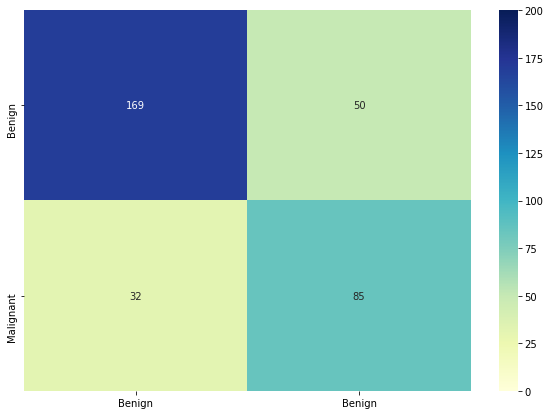

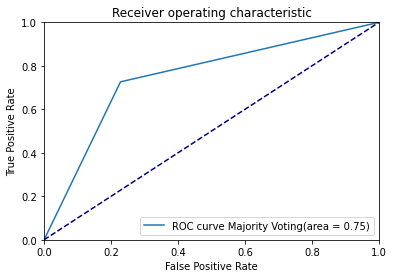

0.7048092868988391


In [ ]:

clf = SVC(gamma='auto')
clf.fit(new_training, labels)
# create test set 

test_predictions = clf.predict(new_test)
print(metrics.confusion_matrix(test_images_labels, test_predictions))
array = metrics.confusion_matrix(test_images_labels, test_predictions)
df_cm = pd.DataFrame(array, index = ["Benign", "Malignant"],
                  columns = ["Benign", "Benign"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, vmin=0, vmax=200, annot=True, fmt="d", cmap="YlGnBu")
print(metrics.classification_report(test_images_labels, test_predictions))
met = metrics.classification_report(test_images_labels, test_predictions,output_dict=True)
print(met['macro avg'])
print(met['accuracy'])
fpr1,tpr1,th1 = metrics.roc_curve(test_images_labels,test_predictions)

roc_auc1 = metrics.roc_auc_score(test_images_labels,test_predictions)

from matplotlib import pyplot as plt
plt.figure()
plt.plot(fpr1, tpr1, label='ROC curve Majority Voting(area = %0.2f)' % roc_auc1)


plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
from sklearn.metrics import fbeta_score

print(fbeta_score(test_images_labels, test_predictions, beta=2))


In [ ]:
import pickle
pickle.dump(clf, open(os.path.join(out_path,"model/ensembling_stacking_svm_bm.sav"), 'wb'))

np.save(os.path.join(out_path,"miscellaneous/stacking_svm_bm_predictions"), test_predictions)

## Gaussian Naive Bayesian

[[150  69]
 [ 31  86]]
              precision    recall  f1-score   support

           0       0.83      0.68      0.75       219
           1       0.55      0.74      0.63       117

    accuracy                           0.70       336
   macro avg       0.69      0.71      0.69       336
weighted avg       0.73      0.70      0.71       336

{'precision': 0.6917839957226876, 'recall': 0.7099871209460251, 'f1-score': 0.6911764705882353, 'support': 336}
0.7023809523809523


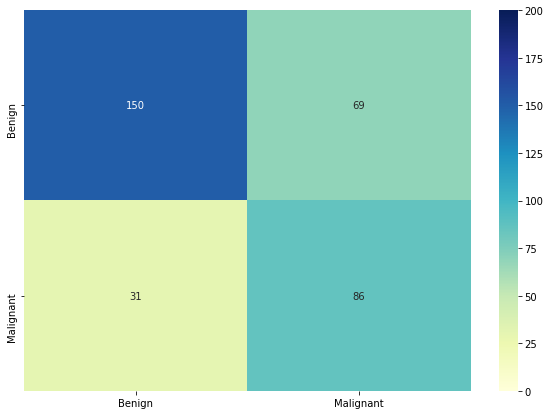

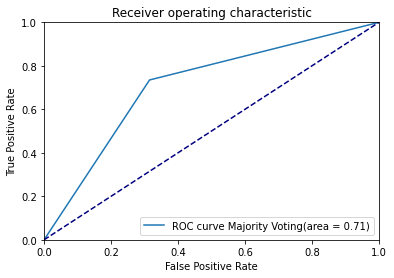

0.6902086677367577


In [ ]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(new_training, labels)
test_predictions = clf.predict(new_test)
print(metrics.confusion_matrix(test_images_labels, test_predictions))
array = metrics.confusion_matrix(test_images_labels, test_predictions)
df_cm = pd.DataFrame(array, index = ["Benign", "Malignant"],
                  columns = ["Benign", "Malignant"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, vmin=0, vmax=200, annot=True, fmt="d", cmap="YlGnBu")
print(metrics.classification_report(test_images_labels, test_predictions))
met = metrics.classification_report(test_images_labels, test_predictions,output_dict=True)
print(met['macro avg'])
print(met['accuracy'])
fpr1,tpr1,th1 = metrics.roc_curve(test_images_labels,test_predictions)

roc_auc1 = metrics.roc_auc_score(test_images_labels,test_predictions)

from matplotlib import pyplot as plt
plt.figure()
plt.plot(fpr1, tpr1, label='ROC curve Majority Voting(area = %0.2f)' % roc_auc1)


plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
print(fbeta_score(test_images_labels, test_predictions, beta=2))


## K-NN 

[[148  71]
 [ 36  81]]
              precision    recall  f1-score   support

           0       0.80      0.68      0.73       219
           1       0.53      0.69      0.60       117

    accuracy                           0.68       336
   macro avg       0.67      0.68      0.67       336
weighted avg       0.71      0.68      0.69       336

{'precision': 0.6686212814645309, 'recall': 0.6840533895328416, 'f1-score': 0.6683608992039259, 'support': 336}
0.6815476190476191


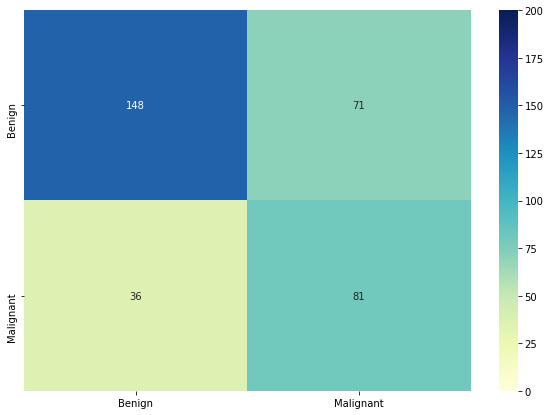

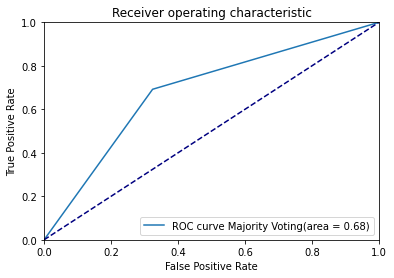

0.6532258064516129


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(new_training, labels)
test_predictions = neigh.predict(new_test)
print(metrics.confusion_matrix(test_images_labels, test_predictions))
array = metrics.confusion_matrix(test_images_labels, test_predictions)
df_cm = pd.DataFrame(array, index = ["Benign", "Malignant"],
                  columns = ["Benign", "Malignant"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, vmin=0, vmax=200, annot=True, fmt="d", cmap="YlGnBu")
print(metrics.classification_report(test_images_labels, test_predictions))
met = metrics.classification_report(test_images_labels, test_predictions,output_dict=True)
print(met['macro avg'])
print(met['accuracy'])
fpr1,tpr1,th1 = metrics.roc_curve(test_images_labels,test_predictions)

roc_auc1 = metrics.roc_auc_score(test_images_labels,test_predictions)

from matplotlib import pyplot as plt
plt.figure()
plt.plot(fpr1, tpr1, label='ROC curve Majority Voting(area = %0.2f)' % roc_auc1)


plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
print(fbeta_score(test_images_labels, test_predictions, beta=2))


## Random Forest

[[151  68]
 [ 38  79]]
              precision    recall  f1-score   support

           0       0.80      0.69      0.74       219
           1       0.54      0.68      0.60       117

    accuracy                           0.68       336
   macro avg       0.67      0.68      0.67       336
weighted avg       0.71      0.68      0.69       336

{'precision': 0.6681783824640968, 'recall': 0.6823556960543262, 'f1-score': 0.6693404634581106, 'support': 336}
0.6845238095238095


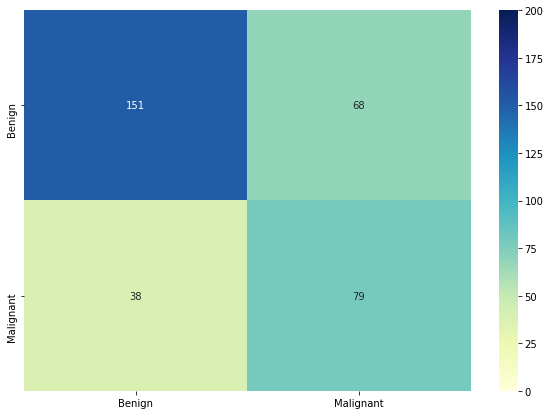

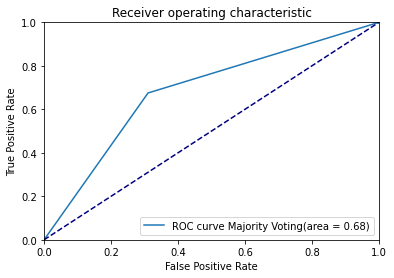

0.6422764227642277


In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(new_training, labels)
test_predictions = clf.predict(new_test)
print(metrics.confusion_matrix(test_images_labels, test_predictions))
array = metrics.confusion_matrix(test_images_labels, test_predictions)
df_cm = pd.DataFrame(array, index = ["Benign", "Malignant"],
                  columns = ["Benign", "Malignant"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, vmin=0, vmax=200, annot=True, fmt="d", cmap="YlGnBu")
print(metrics.classification_report(test_images_labels, test_predictions))
met = metrics.classification_report(test_images_labels, test_predictions,output_dict=True)
print(met['macro avg'])
print(met['accuracy'])
fpr1,tpr1,th1 = metrics.roc_curve(test_images_labels,test_predictions)

roc_auc1 = metrics.roc_auc_score(test_images_labels,test_predictions)

from matplotlib import pyplot as plt
plt.figure()
plt.plot(fpr1, tpr1, label='ROC curve Majority Voting(area = %0.2f)' % roc_auc1)


plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
print(fbeta_score(test_images_labels, test_predictions, beta=2))


## AdaBoost

[[163  56]
 [ 35  82]]
              precision    recall  f1-score   support

           0       0.82      0.74      0.78       219
           1       0.59      0.70      0.64       117

    accuracy                           0.73       336
   macro avg       0.71      0.72      0.71       336
weighted avg       0.74      0.73      0.73       336

{'precision': 0.7087176108915239, 'recall': 0.7225734691488116, 'f1-score': 0.7124559176188461, 'support': 336}
0.7291666666666666


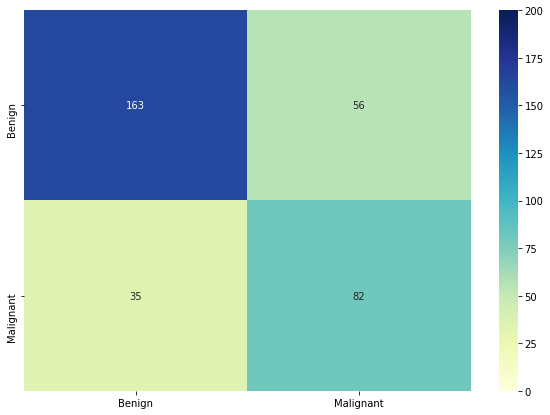

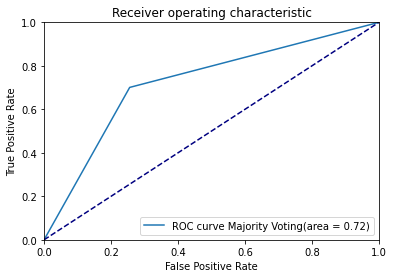

0.6765676567656764


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier()
clf.fit(new_training, labels)
test_predictions = clf.predict(new_test)
print(metrics.confusion_matrix(test_images_labels, test_predictions))
array = metrics.confusion_matrix(test_images_labels, test_predictions)
df_cm = pd.DataFrame(array, index = ["Benign", "Malignant"],
                  columns = ["Benign", "Malignant"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, vmin=0, vmax=200, annot=True, fmt="d", cmap="YlGnBu")
print(metrics.classification_report(test_images_labels, test_predictions))
met = metrics.classification_report(test_images_labels, test_predictions,output_dict=True)
print(met['macro avg'])
print(met['accuracy'])
fpr1,tpr1,th1 = metrics.roc_curve(test_images_labels,test_predictions)

roc_auc1 = metrics.roc_auc_score(test_images_labels,test_predictions)

from matplotlib import pyplot as plt
plt.figure()
plt.plot(fpr1, tpr1, label='ROC curve Majority Voting(area = %0.2f)' % roc_auc1)


plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
print(fbeta_score(test_images_labels, test_predictions, beta=2))
